In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
from pathlib import Path
from time import perf_counter

import catkit
import numpy as np
from ase.build import bulk

from mcmc import MCMC
from mcmc.calculators import LAMMPSRunSurfCalc
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "Cu(100)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Clear jupyter notebook default handler
default_logger = logging.getLogger()
default_logger.handlers.clear()

# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_bulk = bulk("Cu", "fcc", a=3.6147)
slab = catkit.build.surface(
    Cu_bulk,
    size=(2, 2, 2),
    miller=(1, 0, 0),
    termination=0,
    fixed=0,
    vacuum=15.0,
    orthogonal=False,
)

calc_settings = {"pair_style": "eam", "pair_coeff": ["* * Cu_u3.eam"]}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 20,
    "sweep_size": 2,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": True,
    "alpha": 0.99,  # slowly anneal
    "adsorbates": ["Cu"],
    "run_folder": run_folder,
}

Set up LAMMPS (calculator)

In [4]:
# set up the LAMMPS calculator
potential_file = Path(os.environ["LAMMPS_POTENTIALS"]) / "Cu_u3.eam"
lammps_surf_calc = LAMMPSRunSurfCalc(
    files=[potential_file],
    keep_tmp_files=False,
    keep_alive=False,
    tmp_dir=Path.home() / "vssr_tmp_files",
)
lammps_surf_calc.set(**calc_settings)

{'pair_style': 'eam', 'pair_coeff': ['* * Cu_u3.eam']}

Initialize surface system

In [5]:
surface = SurfaceSystem(
    slab,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "Cu_100_2x2x2_all_virtual_ads.cif")

13:34:00 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'Cu(100)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}


13:34:00 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 0.   ,  5.112, 18.307]), array([ 2.556,  0.   , 18.307]), array([ 0.   ,  2.556, 18.307]), array([ 2.556,  2.556, 18.307]), array([ 2.556,  3.834, 18.307])]...
13:34:01 - mcmc.system | INFO: Initializing 16 virtual atoms
13:34:01 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13:34:01 - mcmc.system | INFO: Number of pristine atoms is 8
13:34:01 - mcmc.system | INFO: Bulk indices are [0 1 2 3]
13:34:01 - mcmc.system | INFO: Surface indices are [4 5 6 7]
13:34:01 - mcmc.system | INFO: Constraints are FixAtoms(indices=[0, 1, 2, 3])


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Cu(100)/` folder.

13:34:01 - mcmc.mcmc | INFO: Using run folder Cu(100)


13:34:01 - mcmc.mcmc | INFO: There are 8 atoms in pristine slab
13:34:01 - mcmc.mcmc | INFO: Running with num_sweeps = 20, sweep_size = 2, start_temp = 1.000
13:34:01 - mcmc.mcmc | INFO: Starting with iteration 0
13:34:01 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '0.990', '0.980', '0.970', '0.961', '0.951', '0.941', '0.932', '0.923', '0.914', '0.904', '0.895', '0.886', '0.878', '0.869', '0.860', '0.851', '0.843', '0.835', '0.826']
13:34:01 - mcmc.mcmc | INFO: In sweep 1 out of 20
13:34:01 - mcmc.events.criterion | ERROR: No surface energy found in results dict
13:34:01 - mcmc.system | INFO: Optimized structure has Energy = -26.886
13:34:01 - mcmc.mcmc | INFO: In sweep 2 out of 20
13:34:01 - mcmc.system | INFO: Optimized structure has Energy = -28.482
13:34:01 - mcmc.mcmc | INFO: In sweep 3 out of 20
13:34:01 - mcmc.system | INFO: Optimized structure has Energy = -32.115
13:34:01 - mcmc.mcmc | INFO: In sweep 4 out of 20
13:34:01 - mcmc.system | INFO: Optimized structure has

Time taken = 1.802 seconds


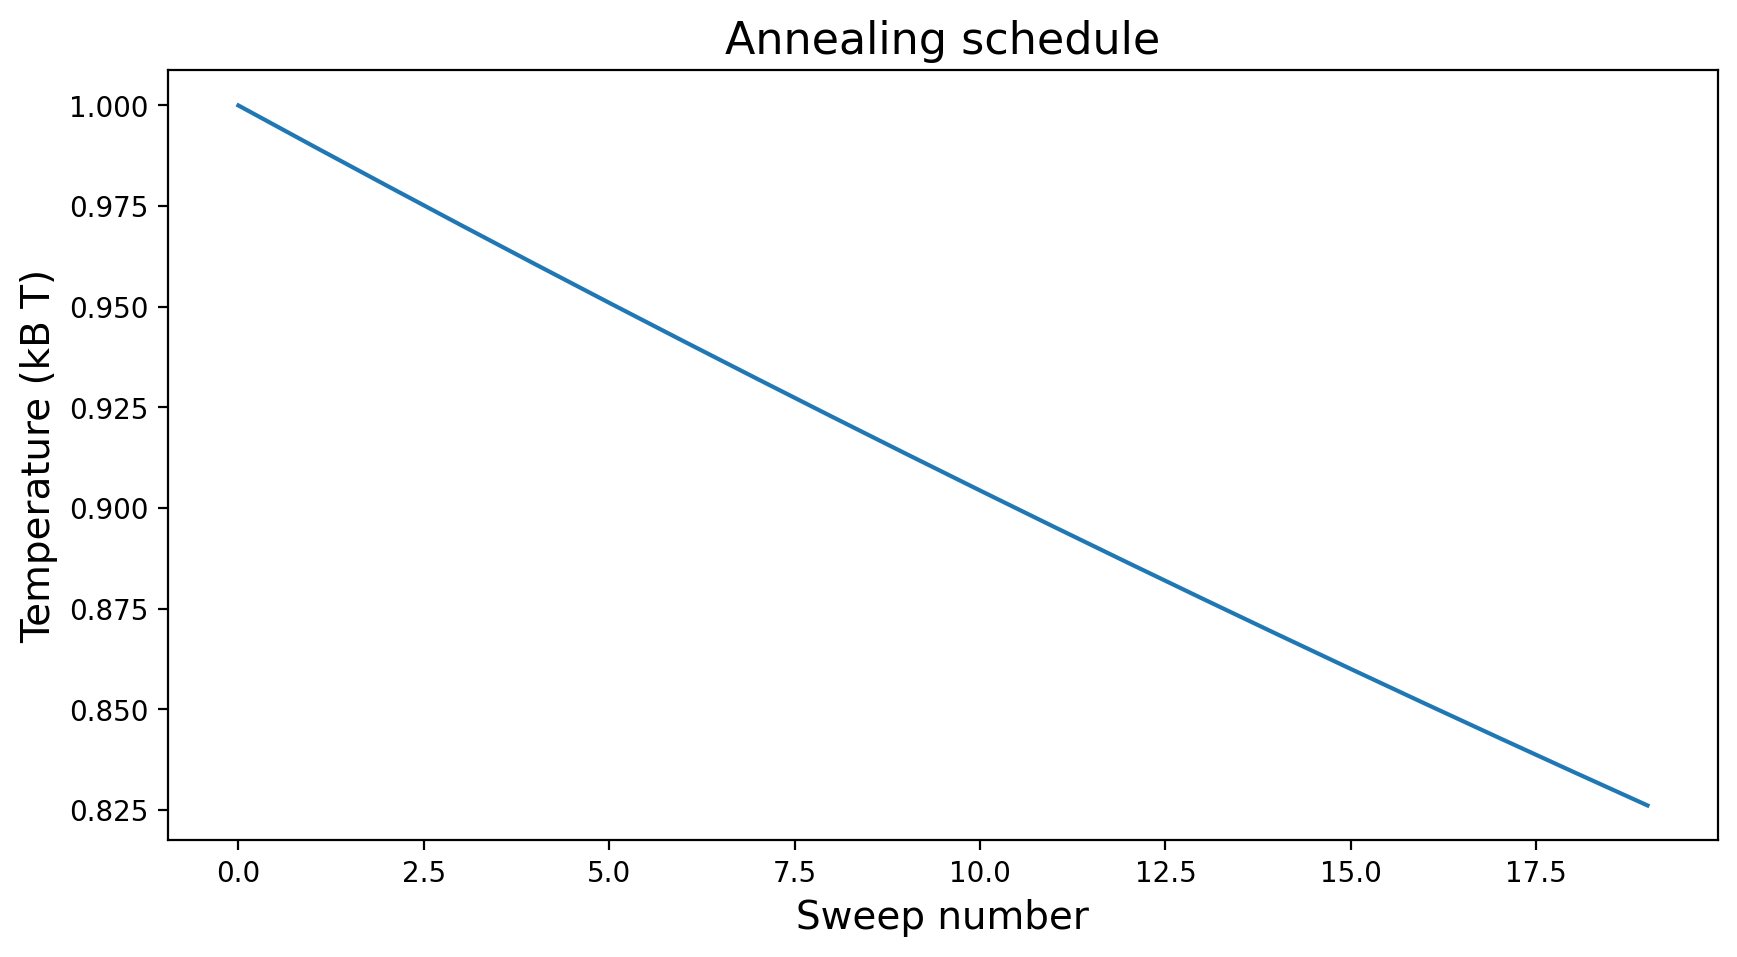

In [6]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Plot results

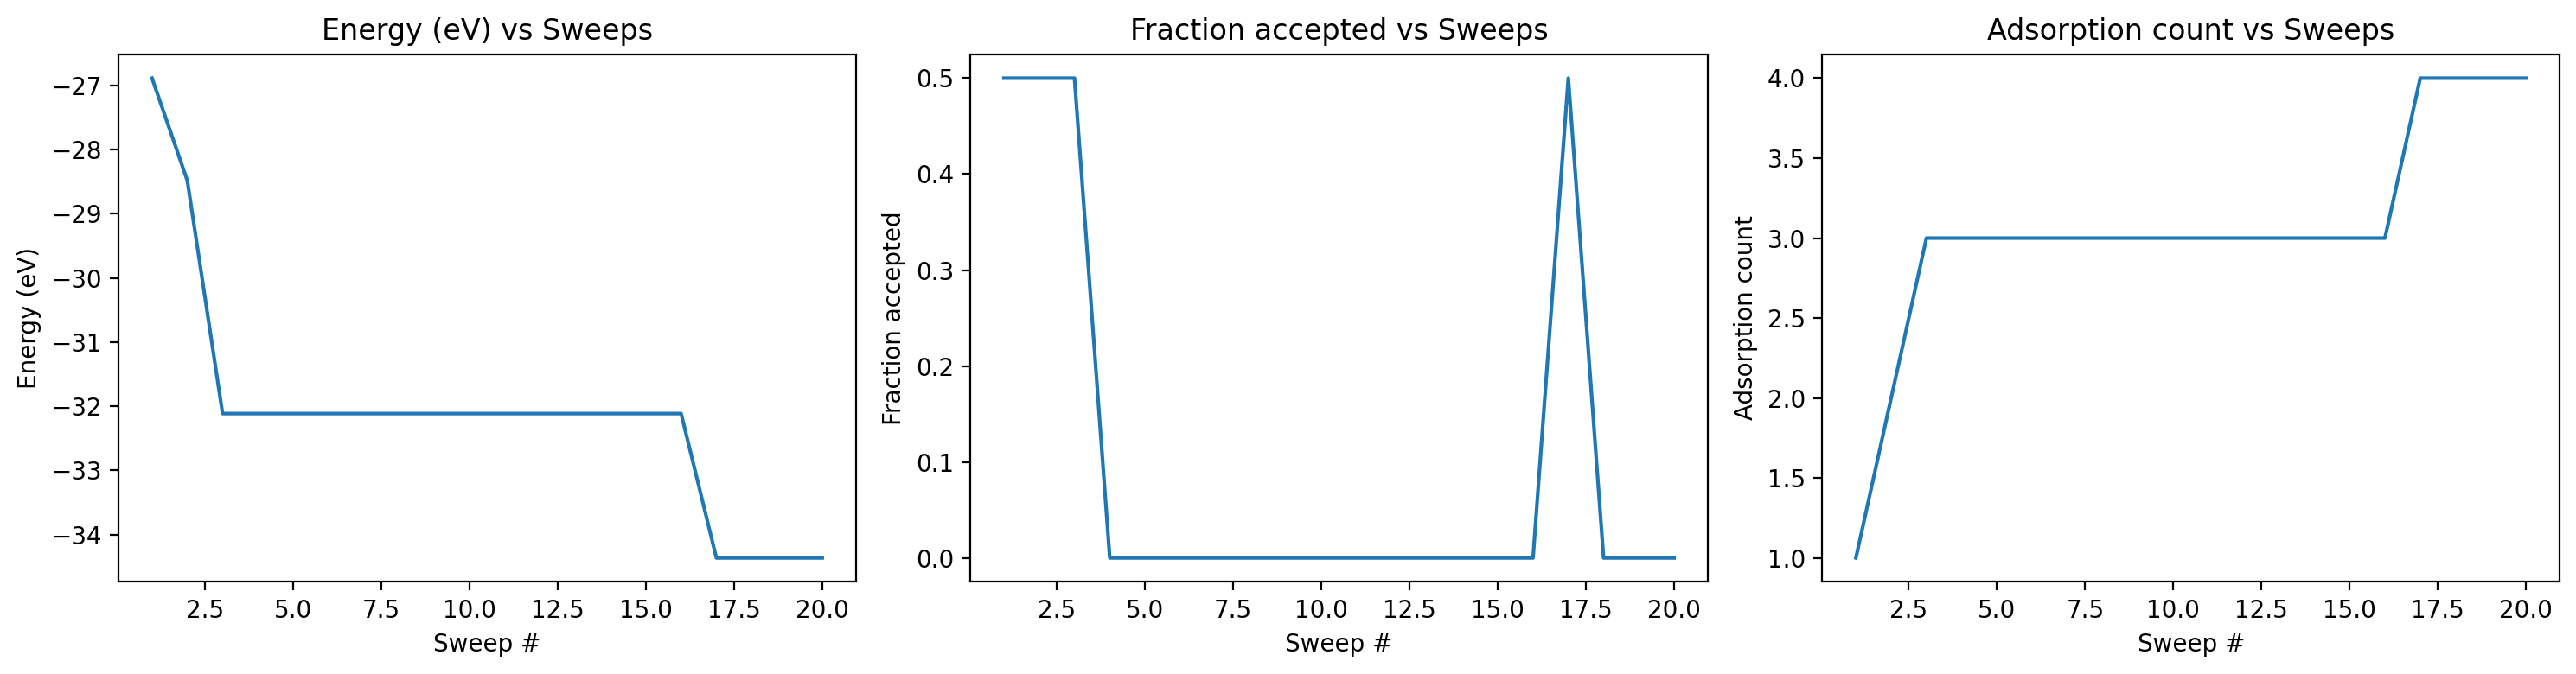

In [7]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)